In [1]:
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import accuracy_score
from scipy.stats import zscore
import pandas as pd
import pickle
import shap
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from json import JSONDecoder, JSONDecodeError  # for reading the JSON data files
import re  # for regular expressions
import os  # for os related operations

import lightgbm as lgb
from tqdm import tqdm_notebook as tqdm

from sklearn import svm
from sklearn.metrics import confusion_matrix

from sklearn.metrics import log_loss
from collections import Counter

from datetime import datetime
from sklearn.model_selection import train_test_split
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', 199)

# print(os.getcwd())

In [2]:
## Read raw data
df = pd.read_csv("data/full_dataframe_1node_2hrs_23dims.csv").drop('timestamp', 1)

## Remove redundant prefix name
prefix = "192.168.13.108.443-"
df.columns = [c.replace(prefix, "") for c in df.columns]

## Min-Max normalization
for c in df.columns:
    df[c] = MinMaxScaler().fit_transform(df[c].values.reshape((df[c].shape[0], -1)))

### Center points
## Read center of clusters
centers_df = pd.read_csv("data/data_cluster.csv")
feature_cols = list(set(centers_df.columns).intersection(set(df.columns)))

## get feature cols only
centers_df = centers_df[feature_cols]

## MinMax norm
for c in feature_cols:
    centers_df[c] = MinMaxScaler().fit_transform(centers_df[c].values.reshape((centers_df[c].shape[0], -1)))

## num of clusters   
len_cluster = centers_df.shape[0]

## convert pandas to list
center_list = [centers_df.iloc[i].values for i in range(len_cluster)]



## get feature cols only
df = df[feature_cols]

my_labels = pd.read_csv("data/pred.csv")

df_full = pd.concat([df, my_labels],1)

df_full.head()

PowerMetricsTotalStoragePower-TotalMemoryPower  DIMMSocketA1TemperatureReading-TemperatureReading  DIMMSocketA3TemperatureReading-TemperatureReading  ThermalTotalPSUHeatDissipation-PowerToCoolRatio  DIMMSocketA6TemperatureReading-TemperatureReading  DIMMSocketA5TemperatureReading-TemperatureReading  CPU2TempTemperatureReading-TemperatureReading  PowerMetricsTotalStoragePower-SystemPowerConsumption  Fan4RPMReading-RPMReading  DIMMSocketA4TemperatureReading-TemperatureReading  Fan1RPMReading-RPMReading  CUPSSystemUsage-IOUsage  CUPSSystemUsage-CPUUsage  Fan3RPMReading-RPMReading  CUPSSystemUsage-MemoryUsage  CPU1TempTemperatureReading-TemperatureReading  ThermalTotalPSUHeatDissipation-SysAirflowPerSysInputPower  DIMMSocketA2TemperatureReading-TemperatureReading  Fan2RPMReading-RPMReading  CUPSSystemUsage-SystemUsage  PowerMetricsTotalStoragePower-TotalCPUPower  Fan5RPMReading-RPMReading  Fan6RPMReading-RPMReading  cluster
0                                             0.6                                                1.0                                                1.0                                              1.0                                                0.0                                                0.0                                            0.0                                              0.034091                        0.0                                                0.0                        0.0                      0.0                       0.0                        0.0                          0.0                                            0.0                                                        1.0                                                0.0                        0.0                          0.0                                     0.231156                        0.0                        0.0        0
1                                             0.6                                                1.0                                                1.0                                              1.0                                                0.0                                                0.0                                            0.0                                              0.034091                        0.0                                                0.0                        0.0                      0.0                       0.0                        0.0                          0.0                                            0.0                                                        1.0                                                0.0                        0.0                          0.0                                     0.231156                        0.0                        0.0        0
2                                             0.6                                                1.0                                                1.0                                              1.0                                                0.0                                                0.0                                            0.0                                              0.034091                        0.0                                                0.0                        0.0                      0.0                       0.0                        0.0                          0.0                                            0.0                                                        1.0                                                0.0                        0.0                          0.0                                     0.231156                        0.0                        0.0        0
3                                             0.6                                                1.0                                                1.0                                              1.0                                                0.0    

In [3]:
df_full["cluster"].value_counts()

0    1698
6    1278
5     441
8     409
4     383
1     340
3     208
7     195
2      76
Name: cluster, dtype: int64

In [4]:
feature_cols

['PowerMetricsTotalStoragePower-TotalMemoryPower',
 'DIMMSocketA1TemperatureReading-TemperatureReading',
 'DIMMSocketA3TemperatureReading-TemperatureReading',
 'ThermalTotalPSUHeatDissipation-PowerToCoolRatio',
 'DIMMSocketA6TemperatureReading-TemperatureReading',
 'DIMMSocketA5TemperatureReading-TemperatureReading',
 'CPU2TempTemperatureReading-TemperatureReading',
 'PowerMetricsTotalStoragePower-SystemPowerConsumption',
 'Fan4RPMReading-RPMReading',
 'DIMMSocketA4TemperatureReading-TemperatureReading',
 'Fan1RPMReading-RPMReading',
 'CUPSSystemUsage-IOUsage',
 'CUPSSystemUsage-CPUUsage',
 'Fan3RPMReading-RPMReading',
 'CUPSSystemUsage-MemoryUsage',
 'CPU1TempTemperatureReading-TemperatureReading',
 'ThermalTotalPSUHeatDissipation-SysAirflowPerSysInputPower',
 'DIMMSocketA2TemperatureReading-TemperatureReading',
 'Fan2RPMReading-RPMReading',
 'CUPSSystemUsage-SystemUsage',
 'PowerMetricsTotalStoragePower-TotalCPUPower',
 'Fan5RPMReading-RPMReading',
 'Fan6RPMReading-RPMReading']

In [5]:
df_full.iloc[0]

PowerMetricsTotalStoragePower-TotalMemoryPower               0.600000
DIMMSocketA1TemperatureReading-TemperatureReading            1.000000
DIMMSocketA3TemperatureReading-TemperatureReading            1.000000
ThermalTotalPSUHeatDissipation-PowerToCoolRatio              1.000000
DIMMSocketA6TemperatureReading-TemperatureReading            0.000000
DIMMSocketA5TemperatureReading-TemperatureReading            0.000000
CPU2TempTemperatureReading-TemperatureReading                0.000000
PowerMetricsTotalStoragePower-SystemPowerConsumption         0.034091
Fan4RPMReading-RPMReading                                    0.000000
DIMMSocketA4TemperatureReading-TemperatureReading            0.000000
Fan1RPMReading-RPMReading                                    0.000000
CUPSSystemUsage-IOUsage                                      0.000000
CUPSSystemUsage-CPUUsage                                     0.000000
Fan3RPMReading-RPMReading                                    0.000000
CUPSSystemUsage-Memo

## TRAIN

num feature_cols = 23 
Training until validation scores don't improve for 200 rounds
[100]	train's multi_logloss: 0.878926	valid's multi_logloss: 0.877786
[200]	train's multi_logloss: 0.504596	valid's multi_logloss: 0.503535
[300]	train's multi_logloss: 0.301684	valid's multi_logloss: 0.300745
[400]	train's multi_logloss: 0.18321	valid's multi_logloss: 0.182466
[500]	train's multi_logloss: 0.112348	valid's multi_logloss: 0.111775
[600]	train's multi_logloss: 0.0691634	valid's multi_logloss: 0.068741
[700]	train's multi_logloss: 0.0426405	valid's multi_logloss: 0.0423393
[800]	train's multi_logloss: 0.0263778	valid's multi_logloss: 0.0261628
[900]	train's multi_logloss: 0.016348	valid's multi_logloss: 0.0162043
[1000]	train's multi_logloss: 0.0101555	valid's multi_logloss: 0.0100589
[1100]	train's multi_logloss: 0.00630646	valid's multi_logloss: 0.00624117
[1200]	train's multi_logloss: 0.00392324	valid's multi_logloss: 0.00387968
[1300]	train's multi_logloss: 0.00244914	valid's multi_lo

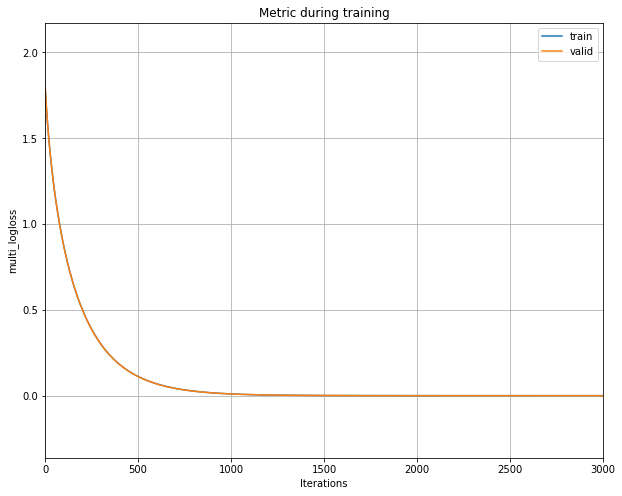

In [6]:
n_jobs = 16
feature_cols = feature_cols
cate_cols = list()
early_stopping = 200

using_SMOTE = False

feature_cols = feature_cols
cate_cols = list()

X_train, X_valid, y_train, y_valid = train_test_split(df_full[feature_cols], df_full["cluster"], test_size=0.33, random_state=2020, stratify = df_full["cluster"])


####################
## RUN THE MODEL ##
###################

## NO need to edit this cell ##

start_time = datetime.now()

random_seed = 2020

print("num feature_cols = {} ".format(len(feature_cols)))

## prepare the model
lgb_params = {
    'boosting_type':'gbdt', 'colsample_bytree':0.5, #'class_weight': {0 : 1. , 1: weight},
    'importance_type':'gain', 'learning_rate':0.005, 'max_depth':3,
    'min_child_samples':20,# 'min_child_weight':0.001, 'min_split_gain':0.0,
    'n_estimators':3000, 'n_jobs': n_jobs, 'num_leaves':31, 'subsample_freq':16,
    'seed': random_seed, 'reg_alpha':0.0, 'reg_lambda':0.0, 'silent':True,
    'subsample':0.5, 'subsample_for_bin':200000,  "metric": "multi_logloss" ,'objective':"multiclass"
}

lgb_model = lgb.LGBMClassifier(**lgb_params)


record_store = dict()
lgb_model.fit( X=X_train, y=y_train, feature_name = feature_cols, #categorical_feature = cate_cols, 
              early_stopping_rounds= early_stopping, eval_set=[(X_train, y_train), (X_valid, y_valid)], 
              eval_names=["train", "valid"],
              eval_metric= "multi_logloss",
              verbose = 100, callbacks = [lgb.record_evaluation(record_store)])

# calc loss error for valid set
y_pred = lgb_model.predict(X_valid)
y_pred_prob = lgb_model.predict_proba(X_valid)


oof = pd.concat([X_valid, y_valid], 1)
oof['pred'] = y_pred
oof['prob_0'] = y_pred_prob[:,0]
oof['prob_1'] = y_pred_prob[:,1]

# plot learning curve 
f = lgb.plot_metric(record_store, figsize=(10,8))
training_time = datetime.now() - start_time

print("done in ", training_time)

# Check the model on trainning set

In [7]:
pred_train = lgb_model.predict(X_train)
print("Accuracy on trainning set", accuracy_score(y_train, pred_train))

Accuracy on trainning set 1.0


# Check the model on trainning set

In [8]:
pred_valid = lgb_model.predict(X_valid)
print("Accuracy on valid set", accuracy_score(y_valid, pred_valid))

Accuracy on valid set 1.0


In [9]:
explainer = shap.TreeExplainer(lgb_model)
shap_values = explainer.shap_values(X_valid)

shap_values_np = np.array(shap_values)
shap.initjs()

# Show feature importance for each feature of each class 

In [10]:
shap_importance = pd.DataFrame({"feature_name": feature_cols})

for i in range(len_cluster):
    shap_class_i = pd.DataFrame({"feature_name": feature_cols, f"cluster_{i}": np.abs(shap_values[i]).sum(axis=0)})
    shap_importance = pd.merge(shap_importance, shap_class_i, on="feature_name", how="inner")
shap_importance

feature_name    cluster_0    cluster_1   cluster_2    cluster_3    cluster_4    cluster_5    cluster_6   cluster_7    cluster_8
0              PowerMetricsTotalStoragePower-TotalMemoryPower   591.985297   468.557303  284.784898     6.675433     0.101654     0.244997    12.756823  192.191508  1433.968069
1           DIMMSocketA1TemperatureReading-TemperatureReading  1382.169761  1644.993352  538.594039     3.451816     3.905094     0.076788     0.797400   78.774321     0.044544
2           DIMMSocketA3TemperatureReading-TemperatureReading   684.600623   911.739469  265.630717     2.266687     1.208925     0.035299     0.110931   40.907524     0.019347
3             ThermalTotalPSUHeatDissipation-PowerToCoolRatio  5483.452568   170.103976   68.074069    80.440688    71.407676    88.959369   813.515396   97.217763  2274.150412
4           DIMMSocketA6TemperatureReading-TemperatureReading     0.000000     0.000000    0.000000     0.000000     0.000000     0.000000     0.000000    0.000000     0.000000
5           DIMMSocketA5TemperatureReading-TemperatureReading     0.000000     0.000000    0.000000     0.000000     0.000000     0.000000     0.000000    0.000000     0.000000
6               CPU2TempTemperatureReading-TemperatureReading   569.251402    10.962461   73.293935   110.877810   197.446882   200.657874    65.545592  917.481231   179.179713
7        PowerMetricsTotalStoragePower-SystemPowerConsumption   330.216483   669.931369  730.924749    42.870015     1.908790    32.250344   144.961496  927.000048  1619.243256
8                                   Fan4RPMReading-RPMReading   366.788219    39.605499   90.877284   681.466719   717.438924   560.700294   777.574455   58.374738    30.002420
9           DIMMSocketA4TemperatureReading-TemperatureReading    14.895788     0.843496    3.202087    30.180217  1380.340257   577.213579     0.005958   22.032399    20.762124
10                                  Fan1RPMReading-RPMReading     0.000000     0.000000    0.000000     0.000000     0.000000     0.000000     0.000000    0.000000     0.000000
11                                    CUPSSystemUsage-IOUsage     0.000000     0.000000    0.000000     0.000000     0.000000     0.000000     0.000000    0.000000     0.000000
12                                   CUPSSystemUsage-CPUUsage     6.424921     0.023630   13.458224   850.094549   567.000256    58.233708  1405.080925  595.639400    15.578712
13                                  Fan3RPMReading-RPMReading     0.000000     0.000000    0.000000     0.000000     0.000000     0.000000     0.000000    0.000000     0.000000
14                                CUPSSystemUsage-MemoryUsage     3.990717     0.178259    0.104167   407.530444   288.347297    14.791294  1690.728387  330.333794     5.740901
15              CPU1TempTemperatureReading-TemperatureReading   211.500113     0.309909   37.457445    53.604569    93.949446    82.211089   149.481542  151.915021    97.020915
16  ThermalTotalPSUHeatDissipation-SysAirflowPerSysInputPower  2867.002626   110.205568   27.891474    35.614736    32.979894    42.262799  3008.478354   65.775610  1143.986625
17          DIMMSocketA2TemperatureReading-TemperatureReading    24.886977     0.017053    0.016765     0.048344   658.278592   448.718559     0.074480    0.734581    88.274486
18                                  Fan2RPMReading-RPMReading    13.856247     1.606749  404.666425  1252.052387   174.026833    49.147250     1.263410  105.272695   158.136240
19                                CUPSSystemUsage-SystemUsage    15.964769     0.023912    0.006953   221.052132  1410.082885   264.667051   397.601763  156.285900   248.756247
20                PowerMetricsTotalStoragePower-TotalCPUPower   733.599670   125.927813  128.367189    10.166689     8.337541     9.779317  2210.559861  490.912175   567.563470
21                                  Fan5RPMReading-RPMReading     0.111824     0.074276  157.995521   405.545935   347.647220  1995.768360   344.986343   4

In [11]:
import plotly.graph_objects as go

x = list(range(len_cluster))

fig = go.Figure()
for i in range(shap_importance.shape[0]):
    fig.add_trace(go.Bar(x=x, y=shap_importance.iloc[i, 1:], name=shap_importance.iloc[i, 0]))


fig.update_layout(barmode='relative', title_text='Feature importance for each cluster, colored by feature names',   
        yaxis=dict(
        title='importance value',
    ),   xaxis=dict(
        title='Cluster',
    ))
fig.show()

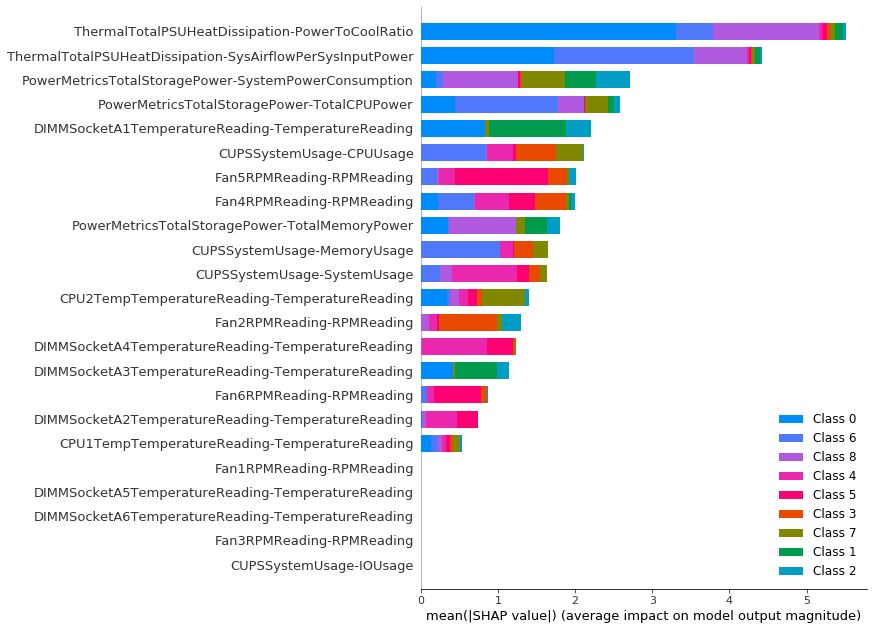

In [12]:
## Feature importance of each feature, colored by cluster

shap.summary_plot(shap_values, X_valid, max_display =  len(feature_cols), show=False, plot_type = "bar")

cluster 0


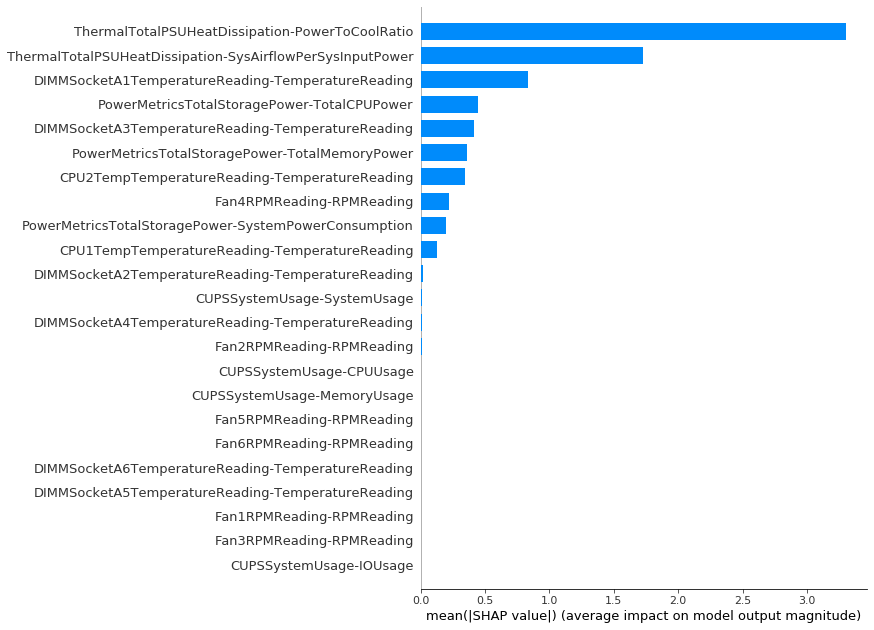



cluster 1


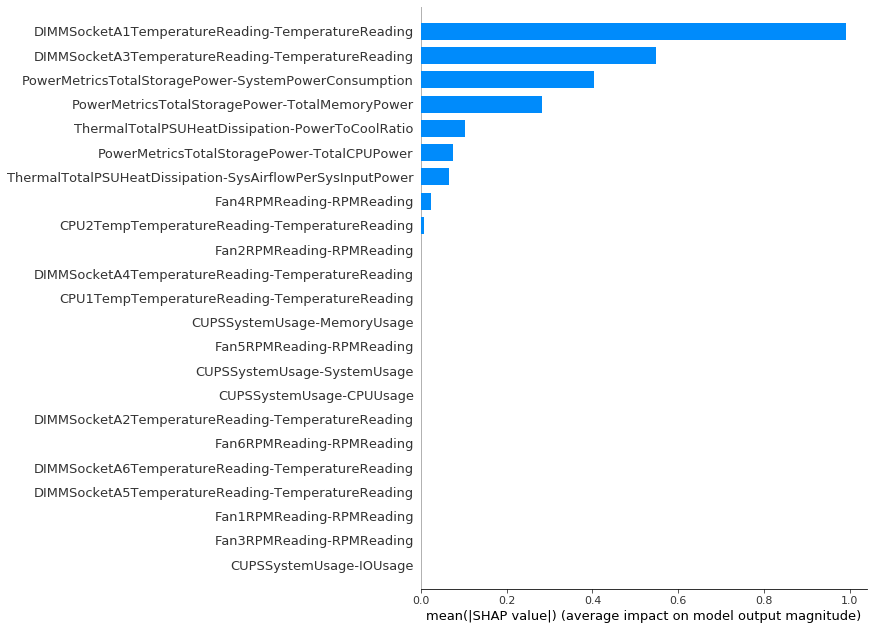



cluster 2


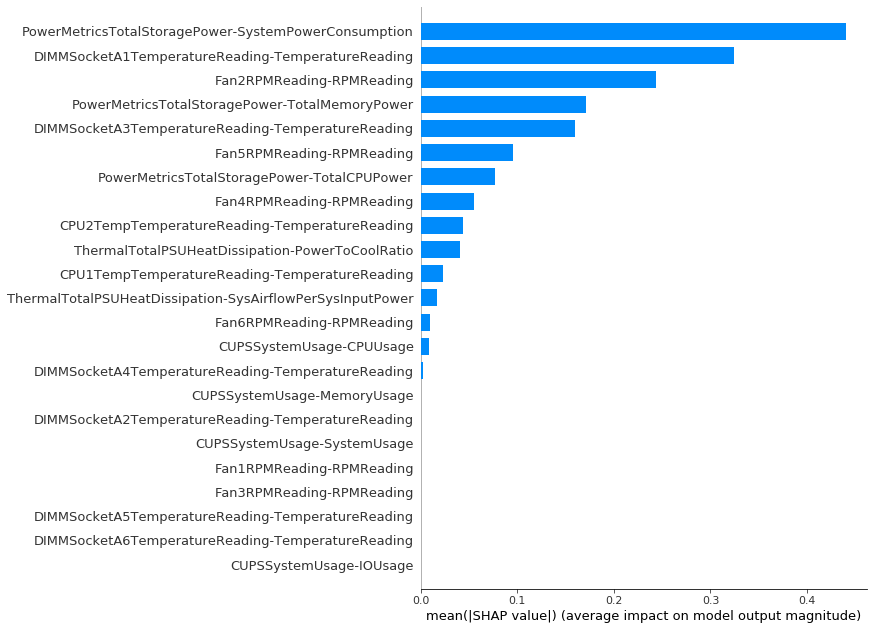



cluster 3


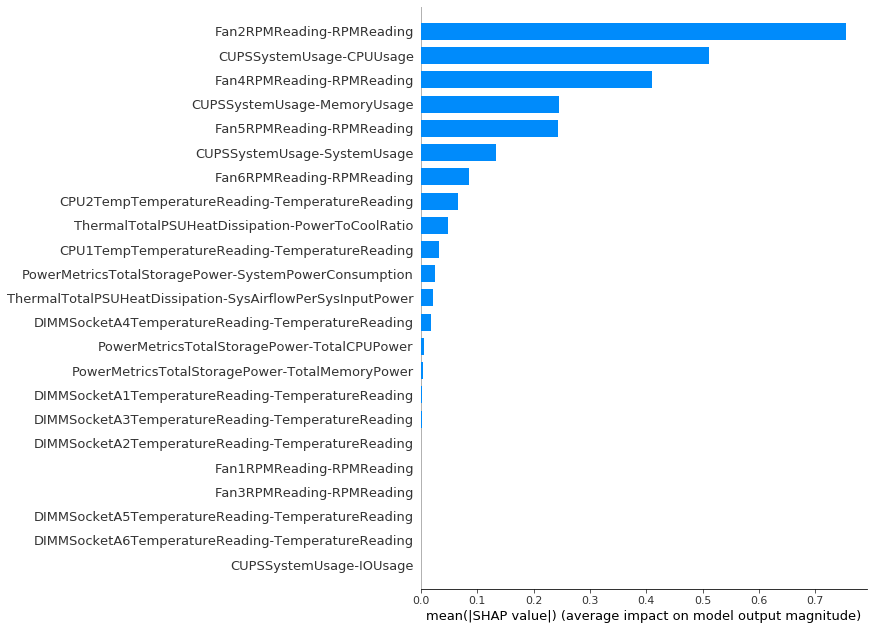



cluster 4


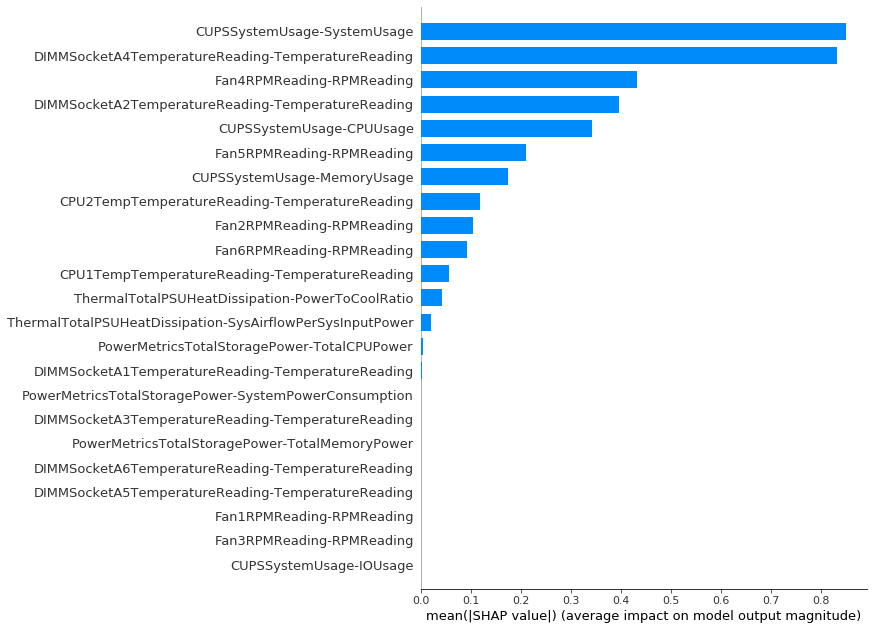



cluster 5


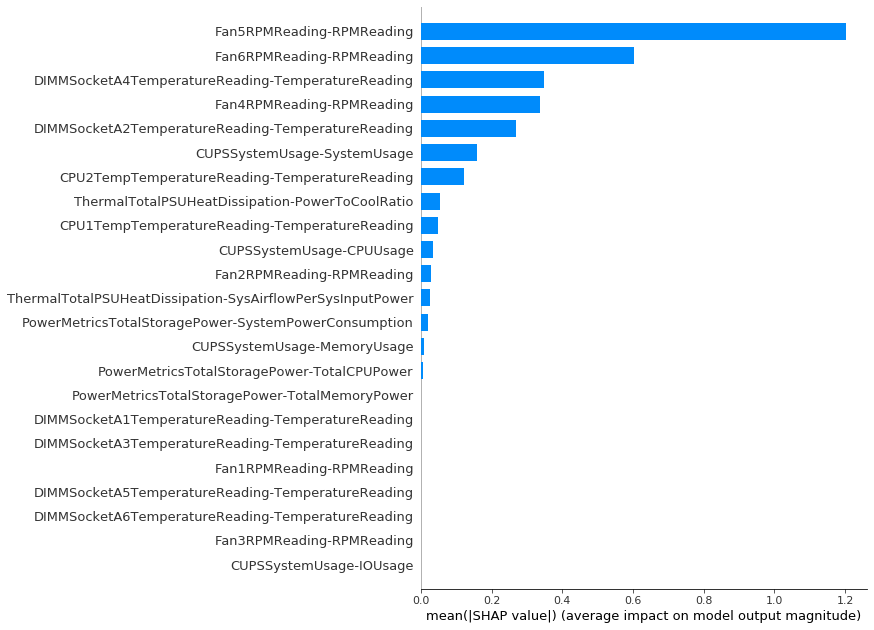



cluster 6


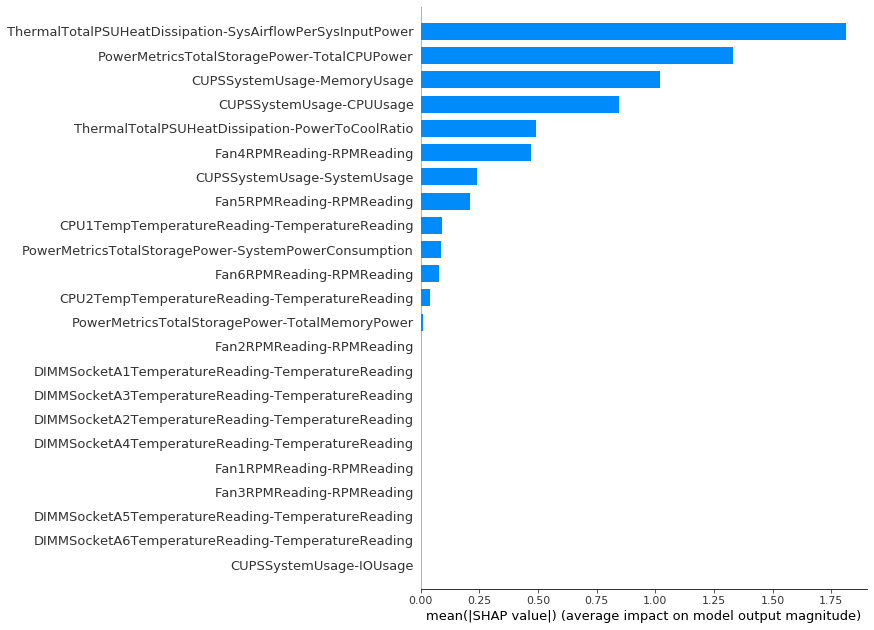



cluster 7


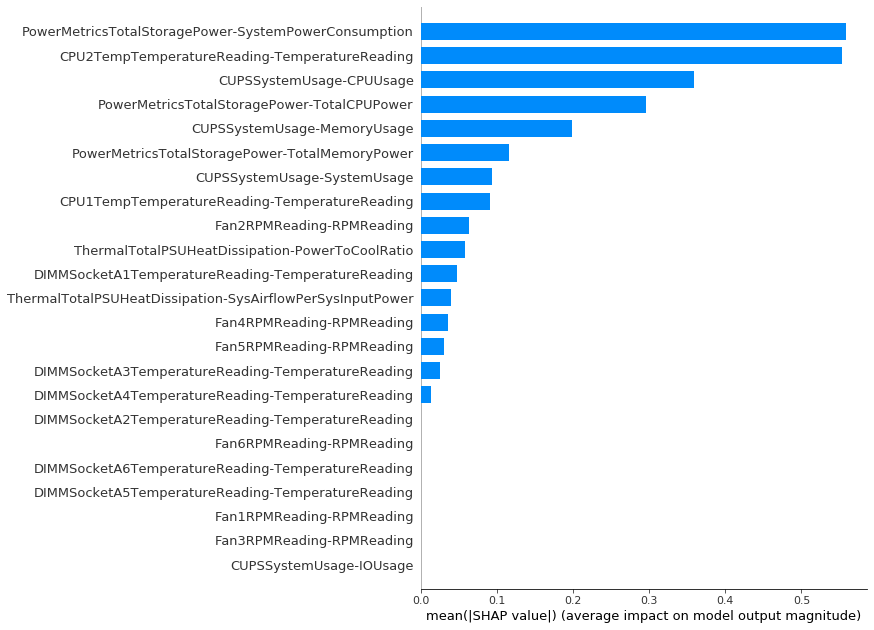



cluster 8


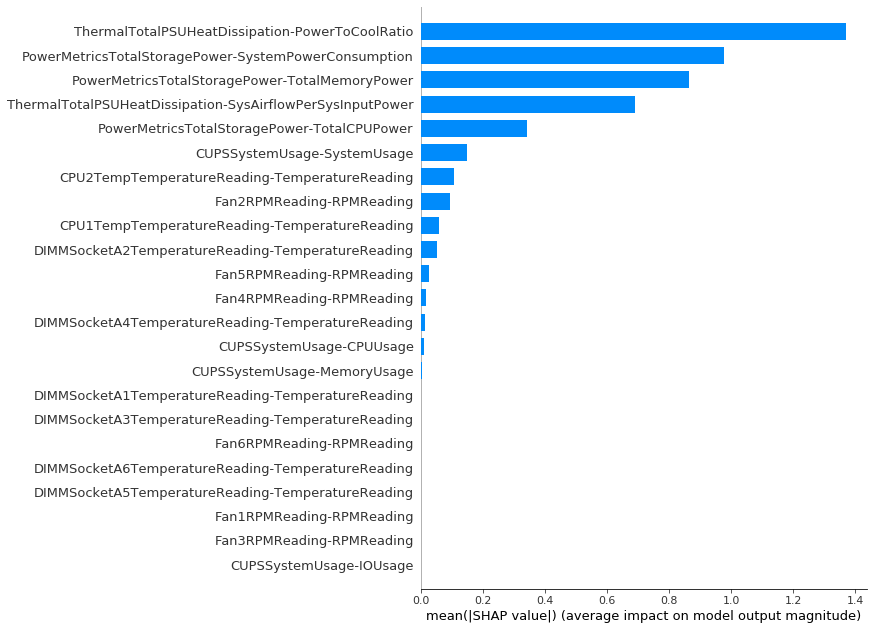

In [13]:
## Show top feature importances of each class
for i in range(len_cluster):
    f = shap.summary_plot(shap_values[i], X_valid, max_display =  len(feature_cols), show=False, plot_type = "bar")
    print("cluster", i)
    plt.show(f)
    print("\n")

# Show feature importance for each instance/observation

In [14]:
i = 0

x = list(range(len(feature_cols)))
fig = go.Figure()
shape_1obs = shap_values_np[:,i,:]
print("pred: Cluster", pred_valid[i])
for i in range(shape_1obs.shape[1]):
    fig.add_trace(go.Scatter(x=x, y=shape_1obs[:,i], name=feature_cols[i], mode='markers'))


fig.update_layout(barmode='relative', title_text='Feature importance for 1 observation, colored by feature names',   
        yaxis=dict(
        title='importance value',
    ),   xaxis=dict(
        title='Cluster',
    ))
fig.show()

pred: Cluster 6


In [16]:
i = 0

x = feature_cols
fig = go.Figure()
shape_1obs = shap_values_np[:,i,:]
print("pred: Cluster", pred_valid[i])
for i in range(len_cluster):
    fig.add_trace(go.Scatter(x=x, y=shape_1obs[i,:], name="cluster "+str(i), mode='markers'))


fig.update_layout(barmode='relative', title_text='Feature importance for 1 observation, colored by feature names',   
        yaxis=dict(
        title='importance value',
    ),   xaxis=dict(
        title='Cluster',
    ))
fig.show()

pred: Cluster 6


Each feature has different contributions on each class.

Ex: Power to cool Ratio has a huge impact on class 0 (blue), whereas much smaller for class 7 (green)

cluster 0


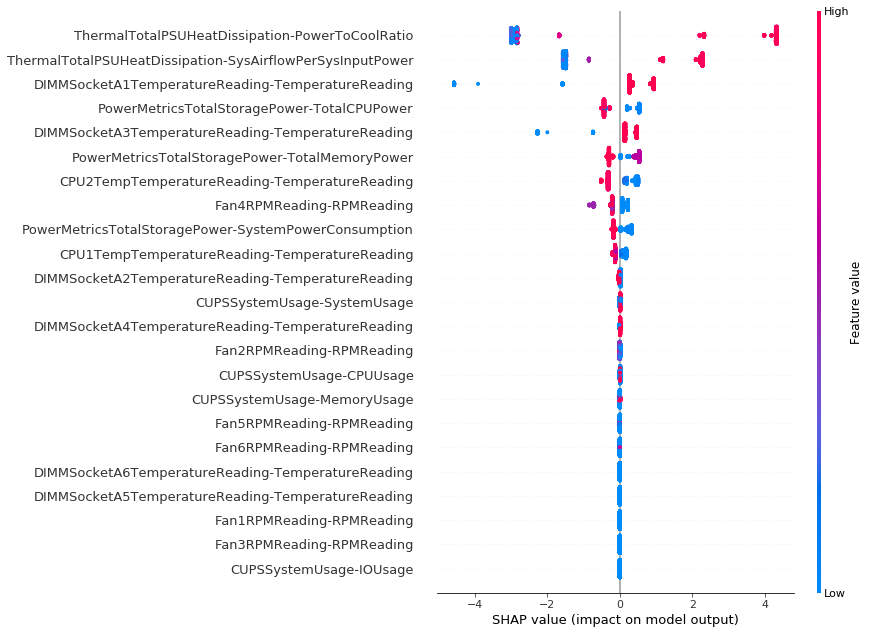



cluster 1


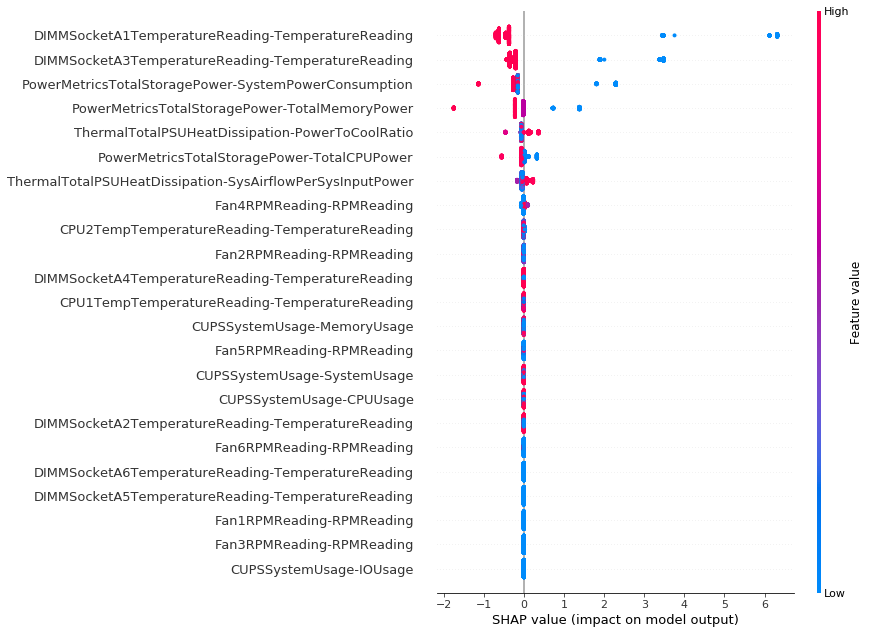



cluster 2


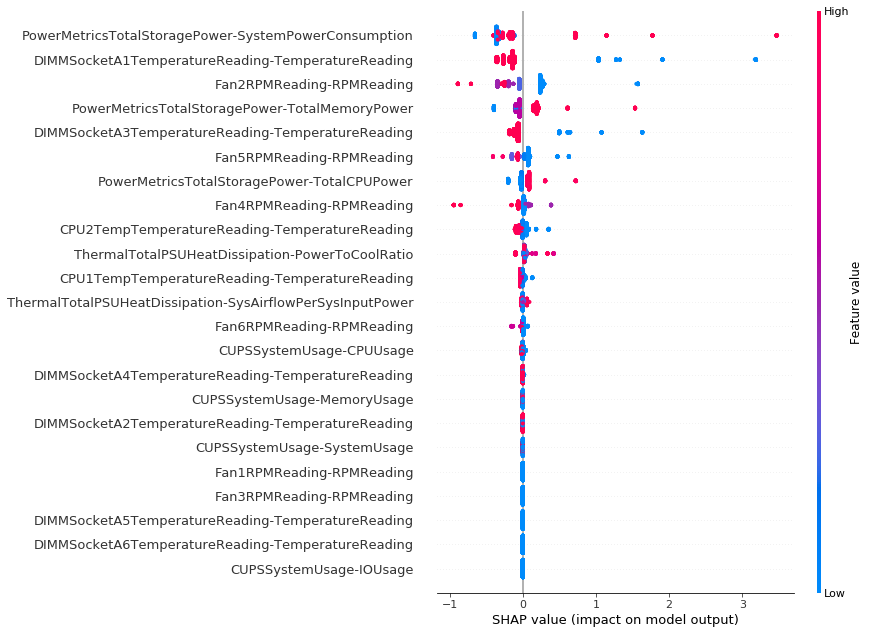



cluster 3


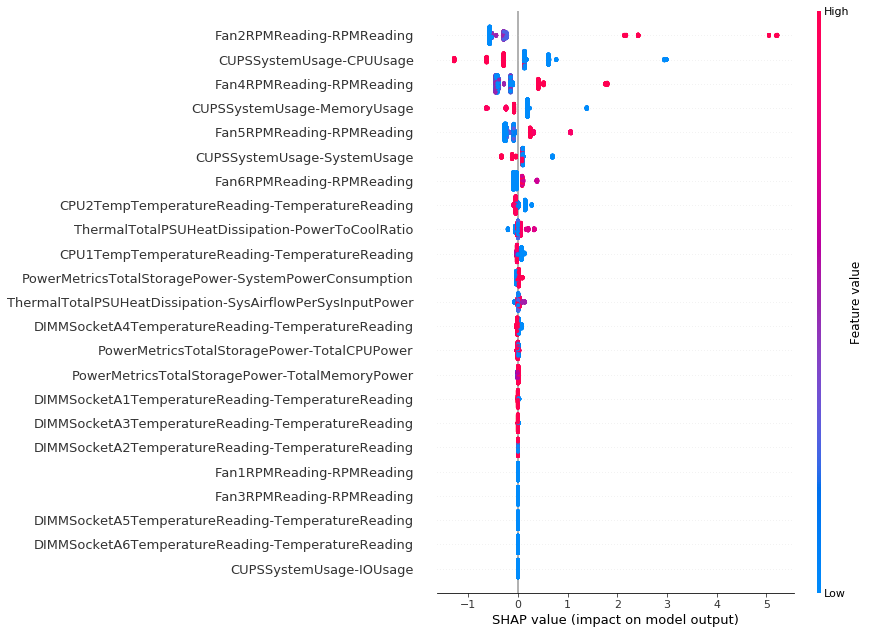



cluster 4


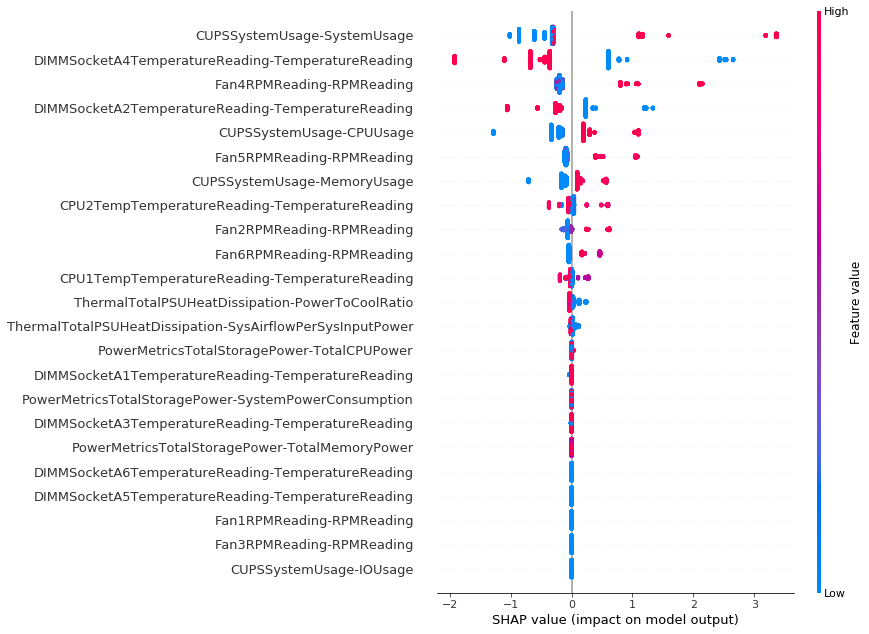



cluster 5


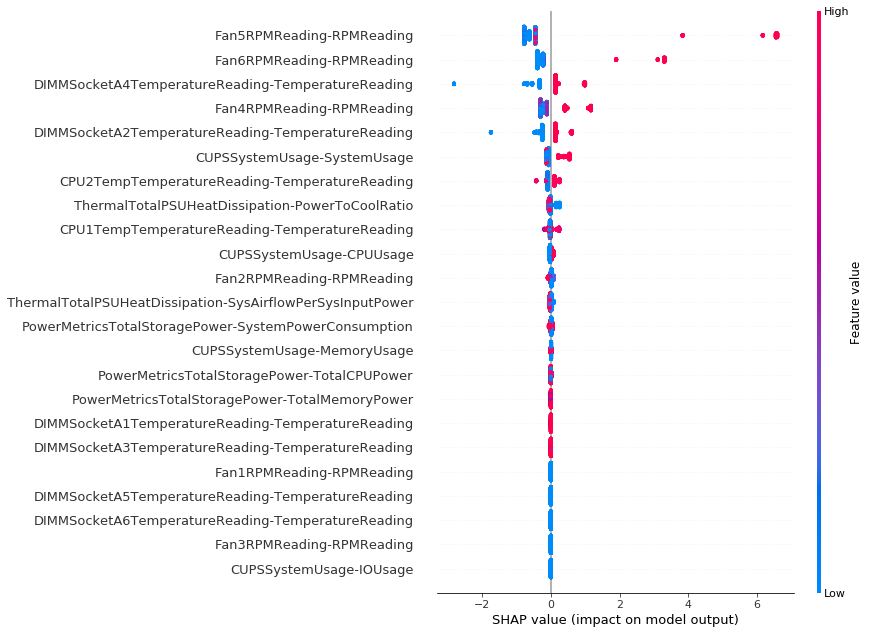



cluster 6


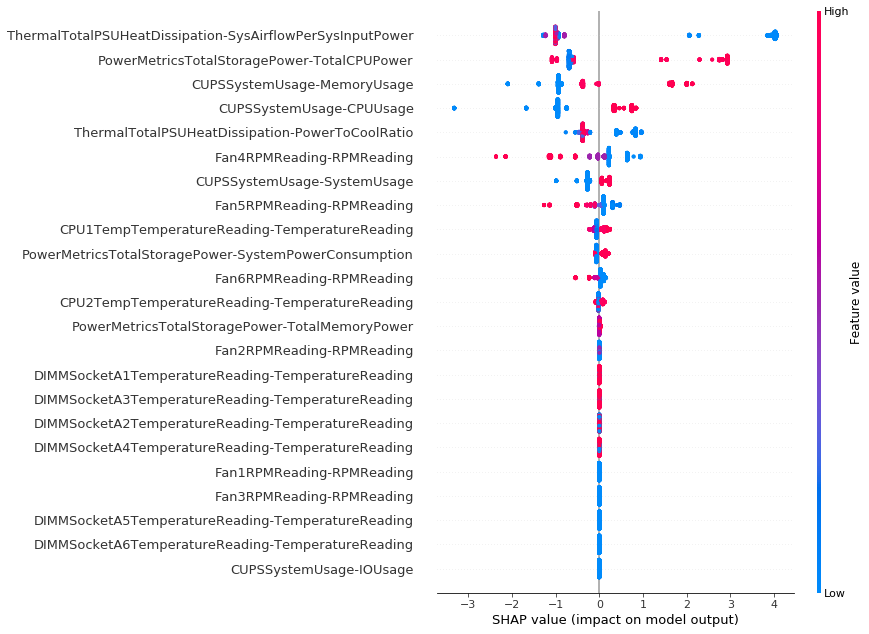



cluster 7


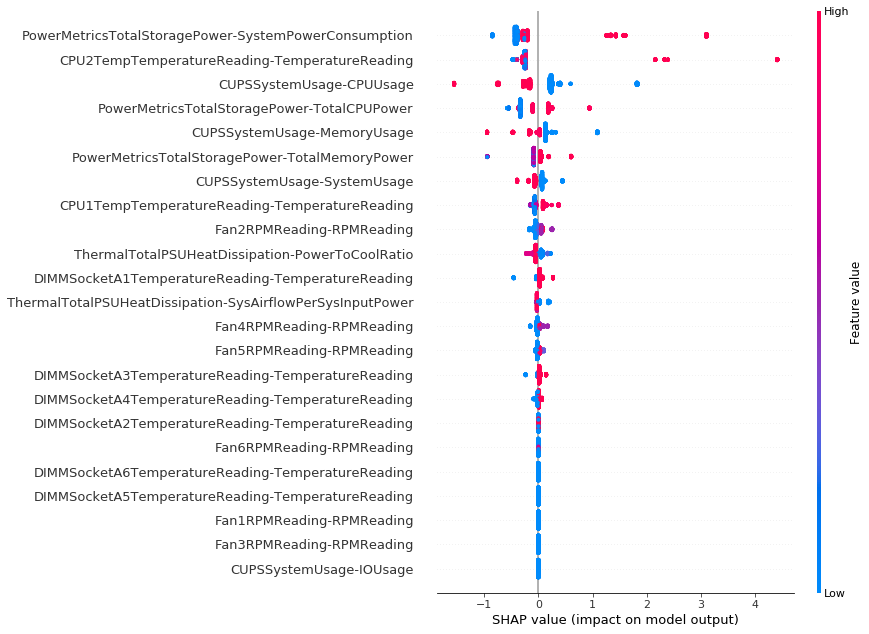



cluster 8


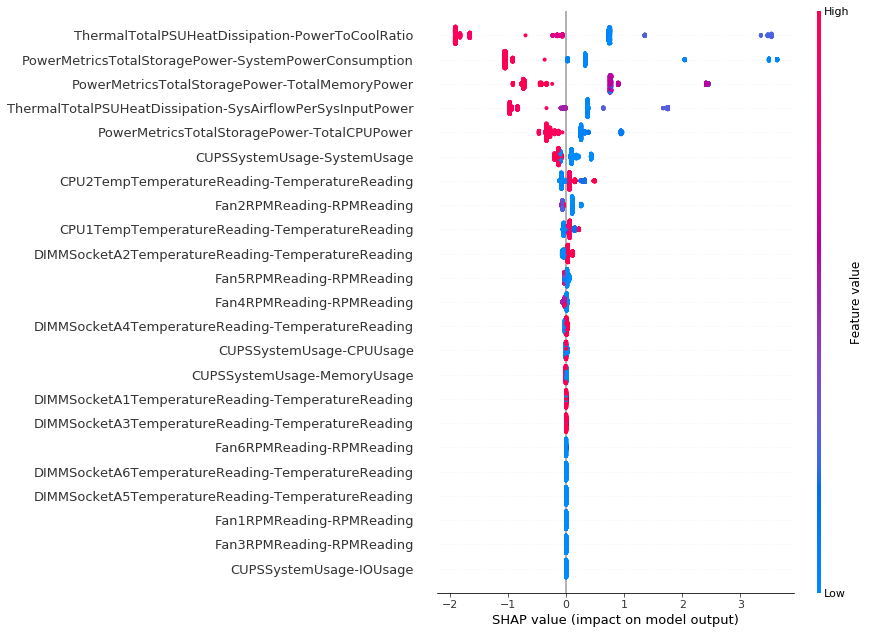

In [17]:
## Show feature importance for each instance/observation by class
for i in range(len_cluster):
    f = shap.summary_plot(shap_values[i], X_valid, max_display = len(feature_cols), show=False, plot_type = "dot")
    print("cluster", i)
    plt.show(f)
    print("\n")